<a href="https://colab.research.google.com/github/jiwooya1000/KOR-Multimodal-Emotion-Recognition/blob/main/1-2.%20%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A6%9D%EA%B0%95(Augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **원천 데이터 Data Augmentation**

### **1-1. 데이터 취합.ipynb에서 생성된 Data_Original.pickle 파일이 디렉토리 내에 필요합니다.**

---
**<<기본 설정>>**

> 텍스트 Augmentation만 적용 : 50%

> 음성 Augmentation만 적용   : 50%

> 전체 Augmentation 적용     : 50%

> 최종 Dataset 크기          : 라벨별 250%
---

## 1. 설정

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [ ]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Data_Original.pickle이 저장된 디렉토리로 변경

directory = "주분"
path = "/content/gdrive/My Drive/" + directory
os.chdir(path)

In [ ]:
import pickle
import gzip
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import gluonnlp as nlp
import random
import sklearn
from sklearn.model_selection import train_test_split 
from kobert.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from augmentation import *

In [ ]:
# 미리 학습된 tokenizer를 불러오기
kobert_tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1", use_fast=False)

In [ ]:
# Data_Original.pickle 불러오기

with gzip.open('Data_Original.pickle','rb') as f:
    data = pickle.load(f)
data.head()

,Audio,Text,Emotion,Arousal,Valence
0,"[[[-46.271706, -56.406227, -45.840088, -44.836...",n/ 아 친구들도? l/,neutral,2.8,3.8
1,"[[[-54.416702, -62.57361, -56.180107, -52.9284...",l/ 나는 생일?,neutral,3.1,3.3
2,"[[[-55.659237, -55.838276, -50.546646, -51.658...",생일날이면은 b/ 내가 고기를 되게 좋아하니까 엄마도 그걸 아니까 미역국도 같이 해...,neutral,3.1,3.3
3,"[[[-63.03308, -58.875835, -57.511215, -57.0118...",b/ 선물이라 이 보통 돈으로 주시지. l/,happy,3.1,3.6
4,"[[[-55.11648, -48.754845, -48.318676, -46.4638...",l/ 용돈으로 주시고.,neutral,3.2,3.5


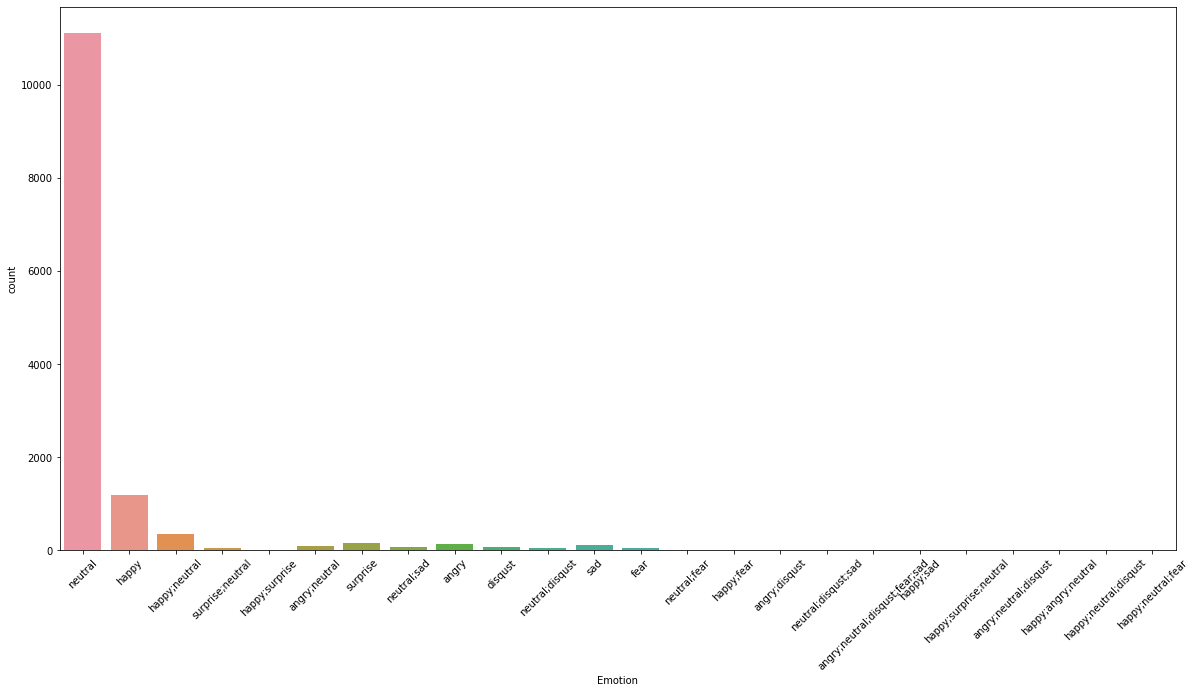

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.countplot(x="Emotion", data=data)

## 2. Label 정리

In [ ]:
emotions = ['neutral', 'happy', 'surprise', 'angry', 'sad']
data = data[data['Emotion'].isin(emotions)].reset_index(drop=True)

## 3. Train, Valid, Test 분리

In [ ]:
# train, test 분리
train, test = train_test_split(data, test_size=0.2, random_state=1, shuffle=True)

# train, valid 분리
train, valid = train_test_split(train, test_size=0.1, random_state=1, shuffle=True)

# index reset
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [ ]:
# shape 확인
train.shape
test.shape
valid.shape

print('train shape:', train.shape, 'test shape:' ,test.shape, 'valid shape:', valid.shape)

train shape: (9161, 5) test shape: (2545, 5) valid shape: (1018, 5)


In [ ]:
train.head()

,Audio,Text,Emotion,Arousal,Valence
0,"[[[-48.80014, -53.394287, -47.190025, -49.031,...",어 나는 워낙 많아 가지고 고등 고등학교 3학년 3학년 한 중반쯤에 만났던 앤데 그...,neutral,3.2,2.5
1,"[[[-54.973846, -52.31526, -58.51277, -61.26166...","근데 이제 진지 이거 진짜예요 진짜, 꾸민 게 아니라.",neutral,3.7,3.8
2,"[[[-44.767715, -46.717567, -55.23369, -57.9519...",c/ 그리고 그걸 또 그걸 또 빌려달라고 하는 남자애들이 있다는 거랑.,neutral,3.5,2.4
3,"[[[-49.928337, -53.0866, -55.302124, -51.03737...",아 뭐였지 그.,neutral,3.5,3.5
4,"[[[-50.406174, -51.11396, -43.607597, -50.8311...",그때도 아마 믿었었을 때였으니까 엄마 아빠가 했겠지 엄마가 어 근데 딱 언니랑 같이...,neutral,3.5,3.6


In [ ]:
test.head()

,Audio,Text,Emotion,Arousal,Valence
0,"[[[-32.611706, -40.704754, -43.800583, -48.981...","어 뭐 말하잖아, 뭐라고.",neutral,2.7,3.2
1,"[[[-42.446842, -40.61912, -38.566677, -42.5249...",그냥 그때 생각났어 갑자기.,happy,3.1,4
2,"[[[-49.344223, -46.565918, -53.195145, -55.958...","1월, 이번 연도 1월?",surprise,3.5,2.9
3,"[[[-38.194786, -41.374622, -41.682507, -39.035...",이게 남편인가 아니면 진짜 아랫사람 보는 거처럼 대하는 거 어렸을 때도 그런 생각이...,neutral,2.7,2.2
4,"[[[-56.393036, -51.530422, -46.11987, -50.2757...",기계랑 특히 얘기하는 게 뭔가 일상생활에서 사람들이 자주 있잖아요.,neutral,3.6,3.9


In [ ]:
valid.head()

,Audio,Text,Emotion,Arousal,Valence
0,"[[[-55.512672, -62.684135, -61.733246, -58.050...",아 l/ 근데 너도 마찬가지야. l/,happy,3.8,4
1,"[[[-56.07441, -58.00986, -62.267685, -60.02328...",c/ 눈이 부시게?,neutral,3.3,3
2,"[[[-54.13335, -53.462902, -51.1234, -49.40057,...",AI 대해서 어떻게 생각해?,neutral,3,3.4
3,"[[[-44.299217, -49.900352, -54.476143, -58.572...",근데 나는 코 고는 소리는 그래도 괜찮은데 이 가는 소리는 뭔가 무서워.,neutral,3.7,2.6
4,"[[[-50.403397, -52.57505, -46.273453, -51.9670...",근데 또 신발 벗으면은 또 발 다칠 거 같기도 하고 그 상황에서는.,neutral,3.2,3


## 4. Test, Valid 토큰화

In [ ]:
# 불용어 제거
for i in tqdm(range(test.shape[0])):
    text = test.iloc[i, 1]
    text = text.replace('c/','').replace('n/','').replace('N/','').replace('u/','').replace('l/','')
    text = text.replace('b/','').replace('*','').replace('+','').replace(',','').replace('?','')
    test.iloc[i, 1] = text

for i in tqdm(range(valid.shape[0])):
    text = valid.iloc[i, 1]
    text = text.replace('c/','').replace('n/','').replace('N/','').replace('u/','').replace('l/','')
    text = text.replace('b/','').replace('*','').replace('+','').replace(',','').replace('?','')
    valid.iloc[i, 1] = text

100%|██████████| 1018/1018 [00:00<00:00, 5152.16it/s]


In [ ]:
# 토큰화
for i in range(0, len(test['Text'])):
  tokenized = kobert_tokenizer.tokenize(test.iloc[i].Text)
  test.loc[i, 'Text'] = tokenized

for i in range(0, len(valid['Text'])):
  tokenized = kobert_tokenizer.tokenize(valid.iloc[i].Text)
  valid.loc[i, 'Text'] = tokenized

## 5. Pickle로 저장 - 토큰화가 완료된 valid, test

In [ ]:
valid 저장
with gzip.open('valid_toknized.pickle','wb') as f:
    pickle.dump(valid, f)

# test 저장
with gzip.open('test_tokenized.pickle','wb') as f:
    pickle.dump(test, f)


## 6. Data Augmentation - train 데이터로 진행

In [ ]:
# train 불용어 제거
for i in tqdm(range(train.shape[0])):
    text = train.iloc[i, 1]
    text = text.replace('c/','').replace('n/','').replace('N/','').replace('u/','').replace('l/','')
    text = text.replace('b/','').replace('*','').replace('+','').replace(',','').replace('?','')
    train.iloc[i, 1] = text

100%|██████████| 9161/9161 [00:01<00:00, 7964.08it/s]


In [ ]:
train.head()

,Audio,Text,Emotion,Arousal,Valence
0,"[[[-48.80014, -53.394287, -47.190025, -49.031,...",어 나는 워낙 많아 가지고 고등 고등학교 3학년 3학년 한 중반쯤에 만났던 앤데 그...,neutral,3.2,2.5
1,"[[[-54.973846, -52.31526, -58.51277, -61.26166...",근데 이제 진지 이거 진짜예요 진짜 꾸민 게 아니라.,neutral,3.7,3.8
2,"[[[-44.767715, -46.717567, -55.23369, -57.9519...",그리고 그걸 또 그걸 또 빌려달라고 하는 남자애들이 있다는 거랑.,neutral,3.5,2.4
3,"[[[-49.928337, -53.0866, -55.302124, -51.03737...",아 뭐였지 그.,neutral,3.5,3.5
4,"[[[-50.406174, -51.11396, -43.607597, -50.8311...",그때도 아마 믿었었을 때였으니까 엄마 아빠가 했겠지 엄마가 어 근데 딱 언니랑 같이...,neutral,3.5,3.6
...,...,...,...,...,...
9156,"[[[-52.66149, -53.32052, -53.342834, -54.32839...",이야 혹시 이제 뭐 만나게 된 뭐 계기나 그런 거는.,neutral,3.1,3.1
9157,"[[[-56.698814, -59.34777, -58.947758, -52.3478...",그냥 오히려 군대 둘 다 갔다 왔잖아 우리가.,neutral,3.5,3
9158,"[[[-68.991394, -69.926254, -68.77756, -71.4115...",음 불편하다기보다는 저는 좀 그 좀 왔다 갔다를 시간 개념적으로 좀 맞춰서가 안 돼...,neutral,3,2.6
9159,"[[[-51.001194, -39.19429, -44.311413, -39.5392...",신랑이 그래 오늘 고생했어 자기도 일 끝나고 왔는데도 그래 고생했어 진짜 그 한마...,neutral,3.5,3.5


In [ ]:
for i in range(0, len(train['Text'])):
  tokenized = kobert_tokenizer.tokenize(train.iloc[i].Text)
  train.loc[i, 'Text'] = tokenized

In [ ]:
train

,Audio,Text,Emotion,Arousal,Valence
0,"[[[-48.80014, -53.394287, -47.190025, -49.031,...","[▁어, ▁나는, ▁워낙, ▁많아, ▁가지고, ▁고, 등, ▁, 고등학교, ▁3, ...",neutral,3.2,2.5
1,"[[[-54.973846, -52.31526, -58.51277, -61.26166...","[▁근, 데, ▁이제, ▁진, 지, ▁이, 거, ▁진짜, 예, 요, ▁진짜, ▁꾸,...",neutral,3.7,3.8
2,"[[[-44.767715, -46.717567, -55.23369, -57.9519...","[▁그리고, ▁그, 걸, ▁또, ▁그, 걸, ▁또, ▁빌려, 달라, 고, ▁하는, ...",neutral,3.5,2.4
3,"[[[-49.928337, -53.0866, -55.302124, -51.03737...","[▁아, ▁뭐, 였, 지, ▁그, .]",neutral,3.5,3.5
4,"[[[-50.406174, -51.11396, -43.607597, -50.8311...","[▁그때, 도, ▁아, 마, ▁, 믿, 었, 었, 을, ▁때, 였, 으니, 까, ▁...",neutral,3.5,3.6
...,...,...,...,...,...
9156,"[[[-52.66149, -53.32052, -53.342834, -54.32839...","[▁이, 야, ▁, 혹, 시, ▁이제, ▁뭐, ▁만나, 게, ▁된, ▁뭐, ▁계, ...",neutral,3.1,3.1
9157,"[[[-56.698814, -59.34777, -58.947758, -52.3478...","[▁그냥, ▁오히려, ▁군, 대, ▁둘, ▁다, ▁, 갔다, ▁, 왔, 잖, 아, ...",neutral,3.5,3
9158,"[[[-68.991394, -69.926254, -68.77756, -71.4115...","[▁음, ▁불편, 하다, 기, 보다는, ▁저, 는, ▁좀, ▁그, ▁좀, ▁왔다, ...",neutral,3,2.6
9159,"[[[-51.001194, -39.19429, -44.311413, -39.5392...","[▁신, 랑, 이, ▁, 그래, ▁오늘, ▁고, 생, 했, 어, ▁자기, 도, ▁일...",neutral,3.5,3.5


In [ ]:
# KoBERT는 RD랑 RS만 사용
# data augumentation 함수 정의

def augumentation(data, text_idx, audio_idx, emo_idx):
  for index in tqdm(text_idx):
    text = data.iloc[index, 1]
    aug_text = RS(text, 0.3)
    add_data = {'Audio': data.iloc[index, 0],
                'Text': aug_text,
                'Emotion': data.iloc[index, 2],
                'Arousal': data.iloc[index, 3],
                'Valence': data.iloc[index, 4]}
    data = data.append(add_data, ignore_index=True)
    
  for index in tqdm(audio_idx):
      audio = data.iloc[index, 0]
      mask_freq = np.random.randint(128, size=1)[0]
      mask_range = np.random.randint(10, 30, size=1)[0]
      freq_range = np.random.randint(-80, 0, size=2)
      aug_audio = audio_mask(audio, mask_freq, mask_range, freq_range)
      add_data = {'Audio': aug_audio,
                  'Text': data.iloc[index, 1],
                  'Emotion': data.iloc[index, 2],
                  'Arousal': data.iloc[index, 3],
                  'Valence': data.iloc[index, 4]}
      data = data.append(add_data, ignore_index=True)
      
  for index in tqdm(emo_idx):
      text = data.iloc[index, 1]
      aug_text = RD(text, 0.3)
      
      audio = data.iloc[index, 0]
      mask_freq = np.random.randint(128, size=1)[0]
      mask_range = np.random.randint(10, 30, size=1)[0]
      freq_range = np.random.randint(-80, 0, size=2)
      aug_audio = audio_mask(audio, mask_freq, mask_range, freq_range)
      
      add_data = {'Audio': aug_audio,
                  'Text': aug_text,
                  'Emotion': data.iloc[index, 2],
                  'Arousal': data.iloc[index, 3],
                  'Valence': data.iloc[index, 4]}
      data = data.append(add_data, ignore_index=True)

  return data 

## 7. Data Augumentation 적용

Happy 

  - 50% 텍스트 변환
  - 남은 50% 오디오 변환
  - 전체에 대해 텍스트+오디오 변환

Happy, Neutral 제외한 감정들

  - 100% 텍스트 변환
  - 100% 오디오 변환
  - 100% 텍+오 변환

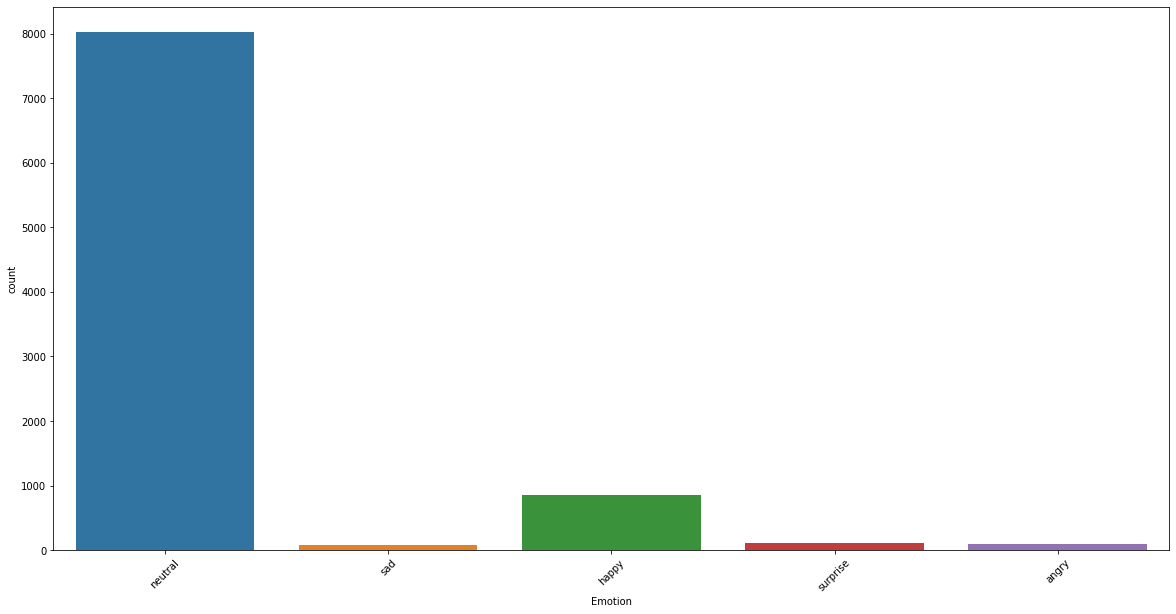

In [ ]:
# 데이터 증강 하기 전
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.countplot(x="Emotion", data=train)

In [ ]:
hap_index = train[train['Emotion'] == 'happy'].index.to_list()
sur_index = train[train['Emotion'] == 'surprise'].index.to_list()
ang_index = train[train['Emotion'] == 'angry'].index.to_list()
neu_index = train[train['Emotion'] == 'neutral'].index.to_list()
sad_index = train[train['Emotion'] == 'sad'].index.to_list()

100%|██████████| 115/115 [00:00<00:00, 299.88it/s]


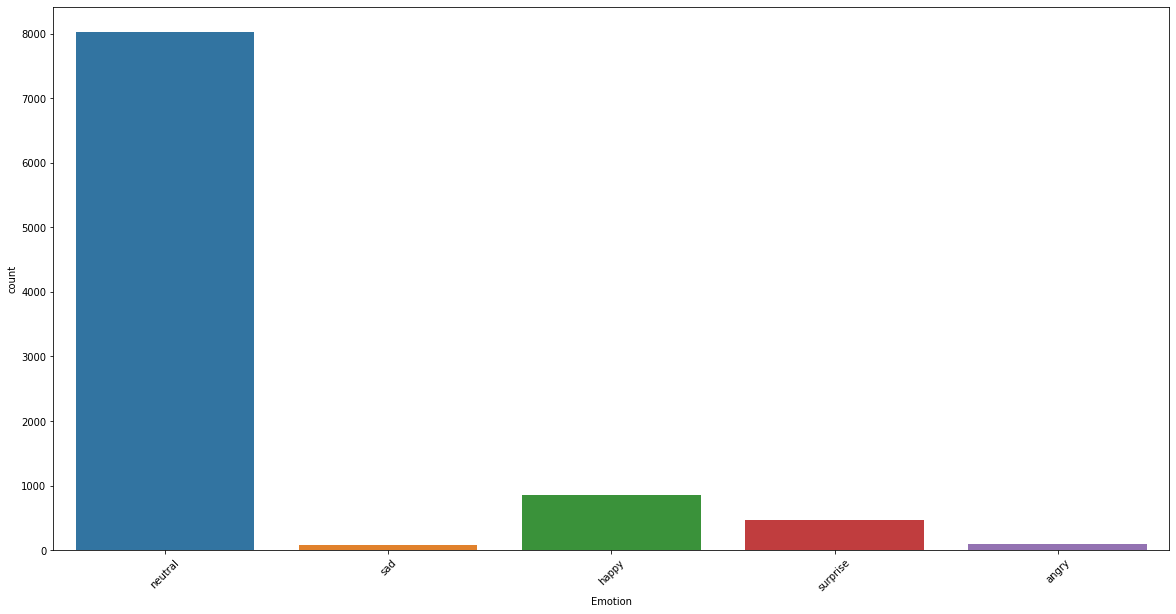

In [ ]:
# surprise - Data Augmentation 적용
train = augumentation(train, sur_index, sur_index, sur_index)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.countplot(x="Emotion", data=train)

100%|██████████| 98/98 [00:00<00:00, 237.10it/s]


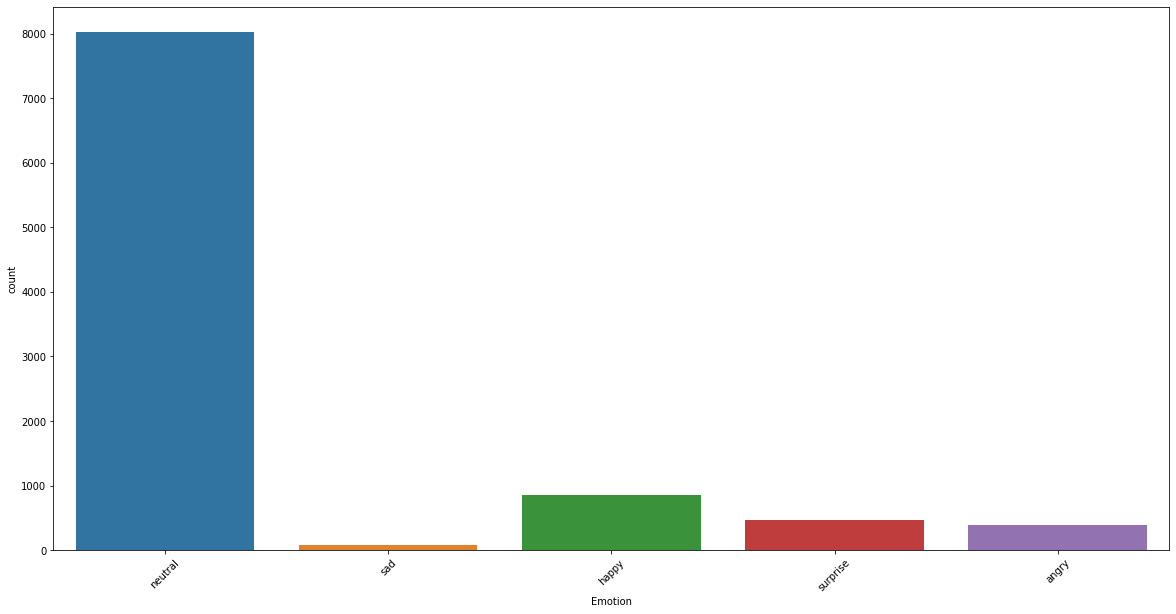

In [ ]:
# angry - Data Augmentation 적용
train = augumentation(train, ang_index, ang_index, ang_index)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.countplot(x="Emotion", data=train)

100%|██████████| 81/81 [00:00<00:00, 250.21it/s]


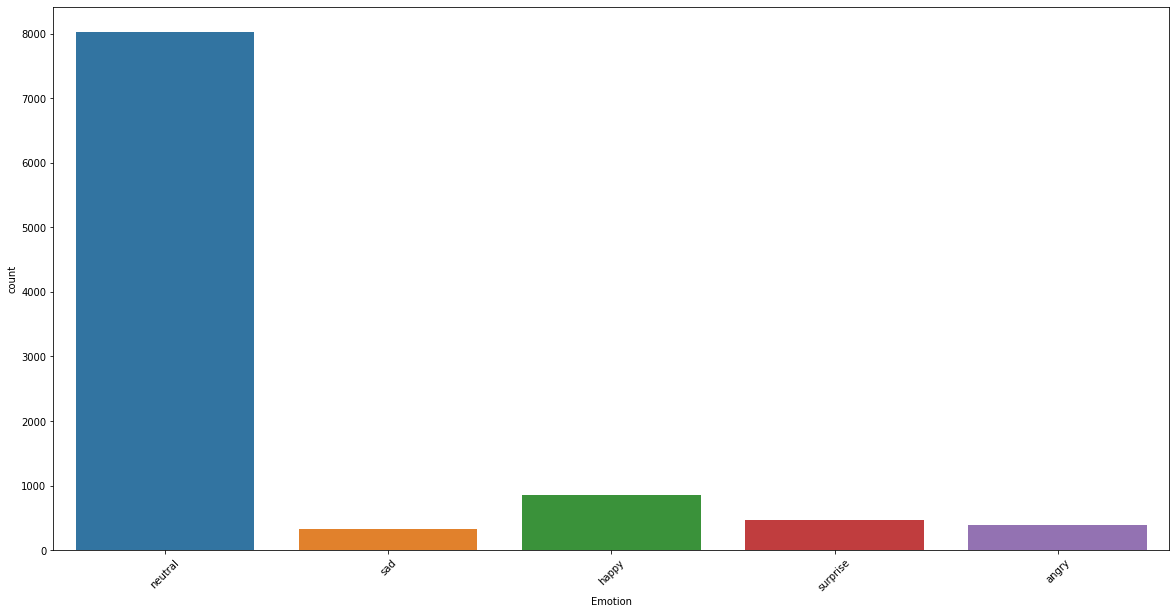

In [ ]:
# sad - Data Augmentation 적용
train = augumentation(train, sad_index, sad_index, sad_index)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.countplot(x="Emotion", data=train)

## 8. Pickle로 저장 - augumentation & tokenization 완료된 train 

In [ ]:
# train - after augumentation 저장
with gzip.open('train_aft_aug_kobert.pickle','wb') as f:
    pickle.dump(train, f)